# Analysis of Gender Bias in Tech Job Postings

### CSE 184: Fall 2019 - Nikhil Dodd, Jerico Factor, Kyle O’Brien, Bryan Jimenez

## Motivation

It's common knowledge that a majority of software engineers identify as male. Despite gains in gender diversity across other STEM professions, software engineering remains largely stagnant. There is a myriad of factors influencing this reality.

We're interested in exploring the role the wording of job postings play in potentially discouraging non-male candidates from applying. This project is inspired by Textio. ----------------FIX

## Questions

1. Out of X randomly collected software engineering jobs, what percentage have gender-specific pronouns?
2. What’s the percentage breakdown by state/region?
3. What are the most common keywords that encourage/discourage applicants?
4. Does the company size or location influence a company's inclusion initiatives? ----------------FIX

## Data Source

As our data source, we'll be using hte LinkedIn job search tool. ----------------FIX

### Import Dependencies 

In [1]:
import numpy as np
import pandas as pd
import nltk
from matplotlib import pyplot as plt
import csv
import requests
import collections
from bs4 import BeautifulSoup
import geopandas as gpd
import pandas_bokeh
from shapely.geometry import Point, Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from math import pi
from bokeh.plotting import figure, output_file, show
import plotly
import plotly.figure_factory as ff
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import csv
import requests
import collections
from bs4 import BeautifulSoup
import re
import json

%matplotlib notebook
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/jrko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Corpus

----- Reasoning and sources

In [2]:
gender_pronouns = [
    "he",
    "him",
    "she",
    "her",
    "his",
    "hers"
]

masculine_themed_wording = [
    "competitive",
    "dominate",
    "leader",
    "rock star",
    "rockstar",
    "guru",
    "ninja",
    "hacker",
    "superhero",
    "prove themselves",
    "analyze",
    "determine",
    "crush it",
    "world class",
    "superior",
    "ambitious",
    "aggressive",
    "leader", 
]

obviously_masculine_subset =[
    'competitive', 
    'dominate', 
    'rockstar',
    'rock star', 
    'ninja', 
    'superhero',
    'world class',
    'superior', 
    'ambitious', 
    'aggressive', 
    'ambitious', 
    'crush it', ]

states = [
    'AL',
    'AK',
    'AZ',
    'AR',
    'CA',
    'CO',
    'CT',
    'DE',
    'DC',
    'FL',
    'GA',
    'HI',
    'ID',
    'IL',
    'IN',
    'IA',
    'KS',
    'KY',
    'LA',
    'ME',
    'MD',
    'MA',
    'MI',
    'MN',
    'MS',
    'MO',
    'MT',
    'NE',
    'NV',
    'NH',
    'NJ',
    'NM',
    'NY',
    'NC',
    'ND',
    'OH',
    'OK',
    'OR',
    'PA',
    'RI',
    'SC',
    'SD',
    'TN',
    'TX',
    'UT',
    'VT',
    'VA',
    'WA',
    'WV',
    'WI',
    'WY' 
]

job_positions = [
    "developer",
    "engineer",
    "software engineer",
    "software developer",
    "product manager",
    "manager",
    "product developer",
    "tech lead",
    "lead",
    "analyst",
    "head",
    "designer"
]

common_job_roles = [
    "engineer", 
    "designer", 
    "manager",
    "analyst",
    "scientist",
    "director"
    "chief officer",
    "sales",
    "marketing",
]



## Load Dataset
Note: Breifly explain data collection process

In [3]:
all_jobs = pd.read_csv("../data/derived_job_data.csv")
all_jobs.head(15)

,job_title,company,location,description
0,MicroStrategy Developers HERE IN McLean VA (Fa...,Advansys Inc,VA,HelloPlease find the below requirement and do ...
1,Security Architect - Palo Alto Firewalls,Alagen,AZ,Alagen has combined over 20 years of recruitin...
2,Dynamics AX Senior System/Security Admin/Globa...,ConsultantFriends.com,IL,MS Dynamics System and Security Admin Global I...
3,IAM Consultant,Collabera,IL,Job ID5457_IAM_ILJob TitleIAM ConsultantJob Lo...
4,.Net Developer,Network Objects Inc.,CT,Net DeveloperHartford CTFULL TIMERequirements5...
5,DevOps Windows/ Linux Engineer,Associated Press,NJ,Position Application EngineerJob SummaryProvid...
6,Solution Architect,Caprus IT Inc.,MI,Hi We do have an urgent requirement Job Title...
7,Immediate openings for Physical Design Enginee...,Calsoft Labs,CA,Job Overview Floor planning PR timing closure...
8,Service Delivery Manager,Matlen Silver,NJ,MUST HAVE ENCRYPTION EXPERIENCE Looking for a ...
9,Management Consultant,Windsor Partners,CA,Duties and ResponsibilitiesConsultants play a ...


### Collect Gendered Jobs

In [4]:
gendered_jobs = pd.DataFrame()

for gendered_word in (gender_pronouns + masculine_themed_wording):
    results = all_jobs.where(all_jobs["description"].str.find(gendered_word) != -1)
    gendered_jobs = pd.concat([gendered_jobs, results])
    
gendered_jobs = gendered_jobs.drop_duplicates(keep=False)
gendered_jobs.shape[0]

2474

### First we'll get the information from the data frame

In [5]:
def stem_tokens(s): 
#This function creates a list of stemmed words from a string
    ps = PorterStemmer()
    tokens = word_tokenize(s)
    stem = list(map(lambda x : ps.stem(x), tokens))
    
    return stem 

In [6]:
tokenized_description = all_jobs['description'].apply(lambda x: ' '.join(stem_tokens(x)))
# tokenized_description = pd.read_csv('dataWithStemmedDescription.csv')['description']

In [7]:
def phraseCount(phrase, description): 
#this counts the amount of times phrase shows up in description
    s = '\\b(' + phrase + ')\\b'
    regex = re.compile(s,re.IGNORECASE)
    return len(re.findall(regex, description))

In [8]:
def indicesOfJobsWithPhrase(phrase, df, descriptionDict): 
# this given a phrase, data frame, stemmed description list
# it will find if the phrase is in the description or the stemmed description
# if it is it will return the indices of these jobs that contain this phrase
    indices = []
    for index, row in df.iterrows(): 
        stemmedPhrase = ' '.join(stem_tokens(phrase))
        if phraseCount(phrase,row.get('description')) > 0 \
        or phraseCount(stemmedPhrase, descriptionDict[index]) > 0: 
            indices.append(index)
    return indices


In [9]:
def computeStateInfo(state, full_df,descriptions,themed_wording): 
# this finds the information of the individual words for this state
# there will be a word count, indicies of the data set where it is found
# number percentage of biased jobs for this state
    stateInfo = {}
    stateInfo['region'] = state
    stateInfo['word_count'] = {}
    stateInfo['word_indices'] = {}
    state_df = full_df.where(full_df['location'] == state).dropna()
    biasedIndices = []; 
    
    for word in themed_wording: 
        
        indices = indicesOfJobsWithPhrase(word, state_df, descriptions)
        stateInfo['word_count'][word] = len(indices)
        stateInfo['word_indices'][word] = indices
        biasedIndices += indices
    
    topWords = [item[0] for item in reversed(sorted(stateInfo['word_count'].items(), key = lambda kv: kv[1]))][:5]
    
    stateInfo['numberOfJobsInDataSet'] = len(state_df)
    stateInfo['numberOfBiasedJobs'] = len(set(biasedIndices))
    try: 
        stateInfo['percentageOfBiasedJobs'] = float(stateInfo['numberOfBiasedJobs']/ stateInfo['numberOfJobsInDataSet']) * 100
    except ZeroDivisionError: 
        stateInfo['percentageOfBiasedJobs'] = 'NA'
                                                                                                               
    stateInfo['questionFour'] = topWords
    stateInfo['questionFive'] = {kv[0]: (kv[1] / stateInfo['numberOfJobsInDataSet'] * 100 if stateInfo['numberOfJobsInDataSet'] > 0 else 'NA')
                                         for kv in stateInfo['word_count'].items()}
    return stateInfo

In [10]:
def exportInfo(DF,themed_wording,name): 
# this function creates a list of dictionaries of state information for all states
# this also writes it to a csv file with the given name
    data = [computeStateInfo(state, DF,tokenized_description,themed_wording) for state in states]
    stateData = data; 
    with open(name+'.json', 'w') as outfile:
        json.dump(stateData, outfile,indent = 4)
    return stateData

In [12]:
import time
startTime = time.time()

themed_wording = masculine_themed_wording
name = 'originalMasculineWords'

stateData = exportInfo(all_jobs,themed_wording,name)

runtime = time.time() - startTime
print("runtime:",runtime)

runtime: 176.62488389015198


In [13]:
def getPercentagesOverall(stateData): 
    numberOfGenderedJobs = sum([state['numberOfBiasedJobs']for state in stateData])
    numberOfJobs = all_jobs.shape[0]
    percentageOfGenderedJobs = numberOfGenderedJobs / numberOfJobs * 100
    print('percentage of gendered jobs:', percentageOfGenderedJobs)
    print('number of gendered jobs:', numberOfGenderedJobs)

## Question 1: What percentage has gender pronouns in the job posting?

Here we will find which job postings contain the actual pronouns in the job listings. We check if they are more biased towards masculine gender pronouns. 

In [14]:
def phraseCount(phrase, description): 
    #this counts the amount of times phrase shows up in description
    s = '\\b(' + phrase + ')\\b'
    regex = re.compile(s,re.IGNORECASE)
    return len(re.findall(regex, description))

In [15]:
def findNumberOfJobsWithPronouns(data_set): 
    mpronouns = ['he', 'him' ,'his']
    fpronouns = ['she', 'her', 'hers']
    pronounCounter = 0
    mascPronounCounter = 0
    femPronounCounter = 0
    for index, row in data_set.iterrows():
        mcount = 0
        fcount = 0
        for word in mpronouns: 
            mcount += phraseCount(word, row.get('description'))
        for word in fpronouns: 
            fcount += phraseCount(word, row.get('description'))
        if mcount + fcount > 0:
            pronounCounter +=1 
        if mcount > fcount: 
            mascPronounCounter += 1
        if mcount < fcount: 
            femPronounCounter += 1

    print('Number of jobs that have gendered pronouns:', pronounCounter, " percentage: ", pronounCounter/data_set.shape[0] * 100)
    print('More masculine pronouns:', mascPronounCounter," percentage: ", mascPronounCounter/pronounCounter * 100)
    print('More feminine pronouns:', femPronounCounter," percentage: ", femPronounCounter/pronounCounter * 100)

In [16]:
findNumberOfJobsWithPronouns(all_jobs)

Number of jobs that have gendered pronouns: 337  percentage:  1.6792904125971695
More masculine pronouns: 123  percentage:  36.49851632047478
More feminine pronouns: 80  percentage:  23.738872403560833


We find that about 1.7% of the job listings in our data set have those gendered phrases. But of those listings, 36% contain more masculine pronouns while only 24% contain more feminine pronouns.

## Questions 2: How are gendered job postings distributed across the USA?

In [17]:
%matplotlib notebook

In [18]:
with open ('originalMasculineWords.json') as jsonfile: 
    jsonInfo = json.load(jsonfile)
getPercentagesOverall(jsonInfo)

percentage of gendered jobs: 34.93621686266693
number of gendered jobs: 7011


<IPython.core.display.Javascript object>


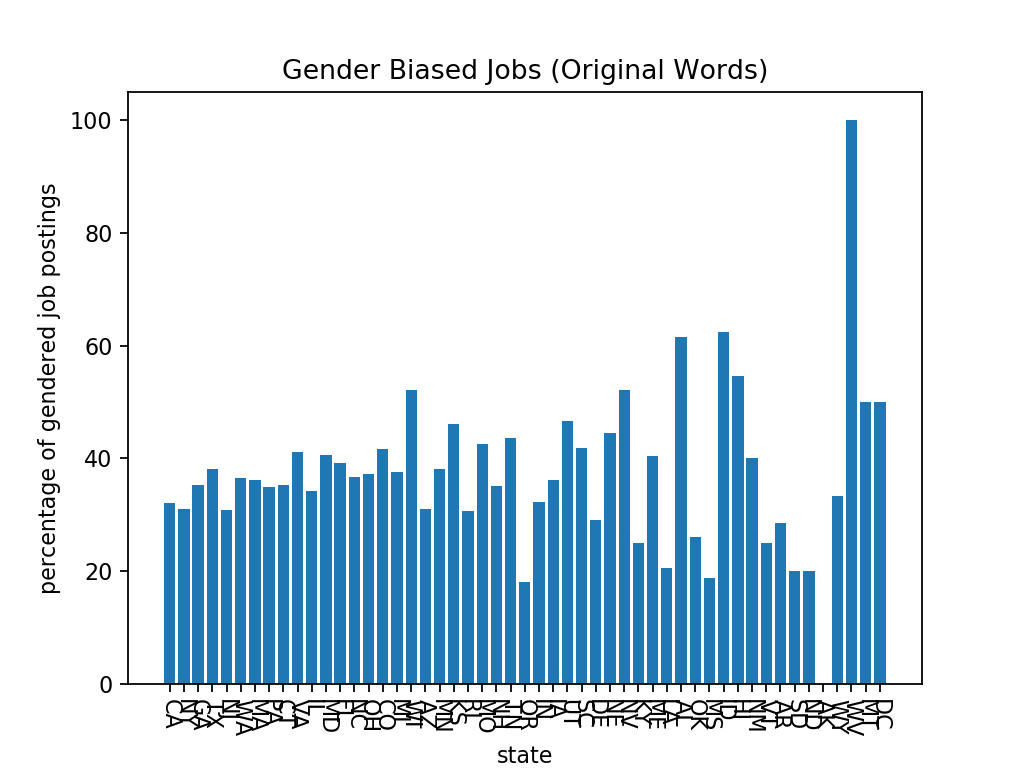

Text(0.5, 1.0, 'Gender Biased Jobs (Original Words)')

In [19]:
fig1 , ax = plt.subplots()
x = [state['region'] for state in reversed(sorted(jsonInfo, key = lambda x: x['numberOfJobsInDataSet'])) if state['percentageOfBiasedJobs'] != 'NA']
y = [float(state['percentageOfBiasedJobs']) for state in reversed(sorted(jsonInfo, key = lambda x: x['numberOfJobsInDataSet'])) if state['percentageOfBiasedJobs'] != 'NA']

ax.bar(x,y)
ax.tick_params(axis='x', which='major', rotation = 270)
ax.set_xlabel('state')
ax.set_ylabel('percentage of gendered job postings')
ax.set_title('Gender Biased Jobs (Original Words)')

This bar graph shows that on average there is about 30% of gendered job across the United States. Since some of our states have much more jobs than others, We ordered the states in the amount of data we had per state. The states towards the end of the graph have single digits. There is no significanct evidence that that some states are more gender biased than others as the percentages are very close to each other

In [20]:
with open ('obviouslyMasculineWording.json') as jsonfile: 
    jsonInfo = json.load(jsonfile)
getPercentagesOverall(jsonInfo)

percentage of gendered jobs: 12.387881203906717
number of gendered jobs: 2486


<IPython.core.display.Javascript object>


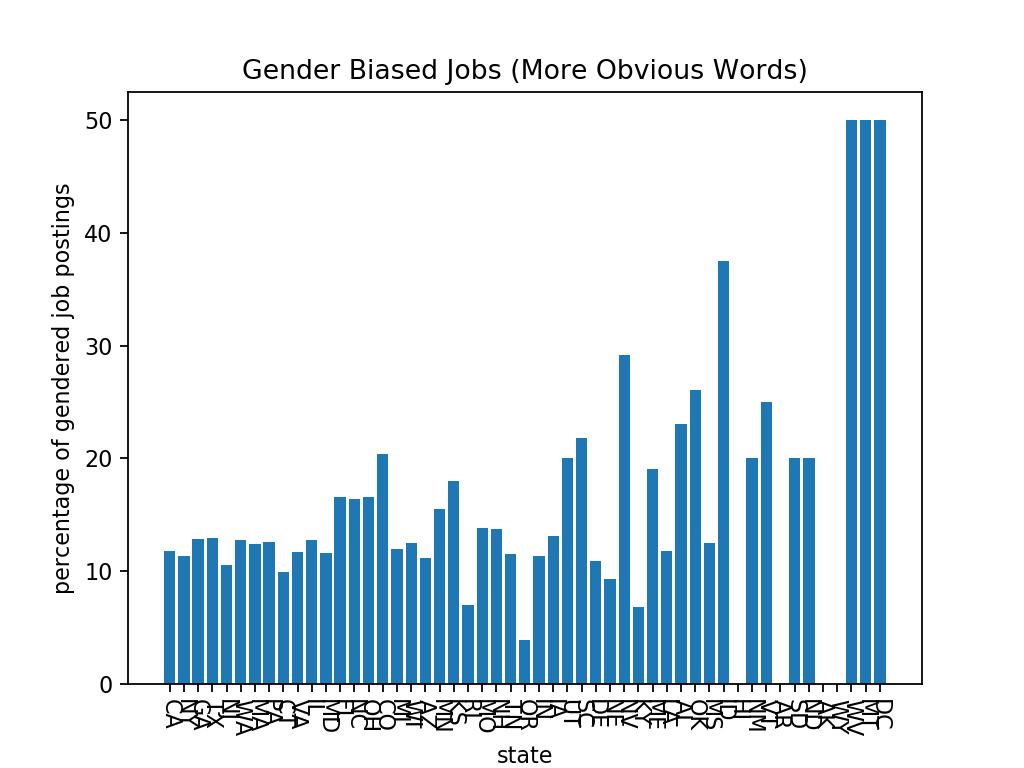

Text(0.5, 1.0, 'Gender Biased Jobs (More Obvious Words)')

In [21]:
fig2 , ax = plt.subplots()
x = [state['region'] for state in reversed(sorted(jsonInfo, key = lambda x: x['numberOfJobsInDataSet'])) if state['percentageOfBiasedJobs'] != 'NA']
y = [float(state['percentageOfBiasedJobs']) for state in reversed(sorted(jsonInfo, key = lambda x: x['numberOfJobsInDataSet'])) if state['percentageOfBiasedJobs'] != 'NA']

ax.bar(x,y)
ax.tick_params(axis='x', which='major', rotation = 270)
ax.set_xlabel('state')
ax.set_ylabel('percentage of gendered job postings')
ax.set_title('Gender Biased Jobs (More Obvious Words)')

By using a subset which we dropped terms that sounded more neutral to us like 'analyze' and 'leader' and taking the percentage of those, we get an average of about 12%

## Question 3: What are the most common roles in tech that have gendered job postings?

Note: Explination and Process

In [22]:
common_roles_occurences = [
    "developer",
    "frontend",
    "backend",
    "UX",
    "engineer",
    "product",
    "manager",
    "lead",
    "analyst",
    "scientist",
    "designer",
    "sales",
    "marketing",
    "accountant",
    "devops"
]

jobs_captured = 0

for role in common_roles_occurences:
    x = all_jobs["job_title"].where(all_jobs["description"].str.find(role) > -1)
    y = gendered_jobs["job_title"].where(gendered_jobs["description"].str.find(role) > -1)
    count = 0
    desc_arr2 = [] # not sure if this array is needed yet, search for the positions

    for item, frame in y.iteritems():
        if pd.notnull(frame):
            count+=1
            desc_arr2.append(item)
            
    jobs_captured += count
    print(f"Uses the word(s) {role}: ", count)
    print(f"percentage {(count / all_jobs.shape[0]) * 100}\n\n")
    
print(jobs_captured)
# NEEEEDS VIZ

Uses the word(s) developer:  260
percentage 1.295594977077935


Uses the word(s) frontend:  65
percentage 0.32389874426948373


Uses the word(s) backend:  92
percentage 0.45844129958142316


Uses the word(s) UX:  82
percentage 0.4086107235399641


Uses the word(s) engineer:  339
percentage 1.6892565278054616


Uses the word(s) product:  559
percentage 2.7855292007175603


Uses the word(s) manager:  97
percentage 0.48335658760215267


Uses the word(s) lead:  290
percentage 1.4450867052023122


Uses the word(s) analyst:  44
percentage 0.21925453458241975


Uses the word(s) scientist:  8
percentage 0.039864460833167234


Uses the word(s) designer:  44
percentage 0.21925453458241975


Uses the word(s) sales:  59
percentage 0.2940003986446083


Uses the word(s) marketing:  39
percentage 0.19433924656169027


Uses the word(s) accountant:  0
percentage 0.0


Uses the word(s) devops:  3
percentage 0.014949172812437711


1981


## Question 4: Out of the gendered words/phrases, which are the most common? 